# Experiments of Toy Multi-variate Gaussian Dataset: Part I (Co-lab version)
(You can just put this file on co-lab and run it. No extra files are needed.)

In [ ]:
!nvidia-smi

Fri Nov 19 06:14:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import packages and set hyper-parameters

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data 
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import plotly.graph_objects as go
import random
import copy
import scipy
import warnings
warnings.filterwarnings("ignore")

def seed_torch(seed=1029):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
seed_torch(1)

K_CLAS = 3                          # Number of classes in the toy dataset
N_Data = int(1e5)                   # Number of samples in the dataset
TVT_SPLIT = [0.05, 0.05, 0.9]       # Split ratio between of train/valid/test dataset
N_Train = int(N_Data*TVT_SPLIT[0])  # Number of training samples
N_Valid = int(N_Data*TVT_SPLIT[1])  # Number of validation samples
N_Test = int(N_Data*TVT_SPLIT[2])   # Number of test samples

BATCH_SIZE = 32                     # Training batch size
EPOCHS = 100                         # Number of training epochs
LR = 5e-4                           # Initial learning rate
LR_MIN = 5e-4                       # Minimum learning rate in cosine scheduler
X_DIM = 30                          # Dimension of input signal x
NOISE = 6                          # Noisy level when generating the dataset

LS_EPS = (1-0.05)                          # Eps of label smoothing, label is y*eps + u*(1-eps)/K_CLAS

MU_VEC = np.random.randint(-1,2,size=(K_CLAS,X_DIM))      # mu_1,...,mu_K
MU_VEC_ALL = np.tile(MU_VEC,(N_Data,1,1))

## Generate the mulit-variate Gaussian Dataset

In this dataset, we have $N$ samples and each sample is a 3-tuple (${x},y,p^*)$. To get one sample, we first select the label $y=k$ following an uniform distribution over all $K$ classes. After that, we sample the input signal ${x}|_{y=k}\sim\mathcal{N}({\mu}_k,\sigma^2I)$, where $\sigma$ is the noisy level for all the samples. ${\mu}_k$ is the mean vector for all the samples in class $k$. Each ${\mu}_k$ is a 30-dim vector, in which each dimension is randomly selected from $\{-1,0,1\}$. Such a process is similar to selecting 30 different features for each class. Finally, we calculate the true Bayesian probability of this sample, i.e., $p^*(y|{x})$.

To calculate $p^*(y|{x})$, we use the fact that $p^*(y|{x})\propto p({x}|y)p(y)$. As $y$ follows an uniform distribution, we have $p^*(y|{x})=\frac{p({x}|y=k)}{\sum_{j\neq k}p({x}|y=j)}$. Following $p({x}|y=k)\sim\mathcal{N}({\mu}_k,\sigma^2I)$, we find $p^*(y|{x})$ should have a Softmax form, i.e., $p=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}}$. Specifically, we have:

\begin{equation}
    p^*(y=k|{x})=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}};\quad s_i = -\frac{1}{2\sigma^2}\|{x}-{\mu}_i\|^2_2
\end{equation}

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def data_gen(x,y,p):
  '''
    Pack everything to a train_loader and a val_lodaer
  '''
  x, y, p = torch.tensor(x), torch.tensor(y), torch.tensor(p)
  dataset=Data.TensorDataset(x, y, p)
  indices = list(range(N_Data))
  np.random.shuffle(indices)
  train_indices, val_indices, test_indices = indices[:N_Train], indices[N_Train:N_Train+N_Valid], indices[N_Train+N_Valid:]
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices) 
  test_sampler = SubsetRandomSampler(test_indices) 
  train_loader = Data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last = True)
  valid_loader = Data.DataLoader(dataset, batch_size=N_Valid, sampler=valid_sampler, drop_last = True)
  test_loader = Data.DataLoader(dataset, batch_size=N_Test, sampler=test_sampler, drop_last = True)
  return train_loader, valid_loader, test_loader

# =========== Generate all x, y and p===============================
y_true = np.random.randint(0,K_CLAS,[N_Data,1]).astype(np.float32)
mu_true = np.zeros((N_Data, X_DIM))
for i in range(N_Data):
  mu_true[i,:] = MU_VEC[y_true[i].astype(np.int),:]
x_true = mu_true + np.random.randn(N_Data, X_DIM)*np.sqrt(NOISE)

logits = np.zeros((N_Data,K_CLAS))
for k in range(K_CLAS):
  logits[:,k] = np.linalg.norm(x_true - MU_VEC_ALL[:,k,:], axis=1)**2*(-0.5/NOISE)
logits = torch.from_numpy(logits)
p_true = F.softmax(logits, 1)

In [ ]:
train_loader, valid_loader, test_loader = data_gen(x_true,y_true,p_true)

## Observe the tSNE plot and histogram of $\mathbf{p}^*$

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=20).fit_transform(x_true[:3000])

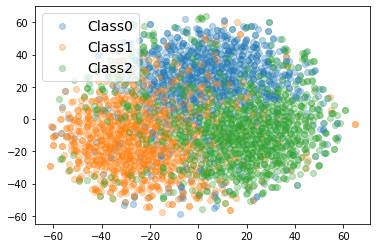

In [ ]:
for k in range(K_CLAS):
  plt.scatter(X_embedded[y_true[:3000].squeeze()==k,0],X_embedded[y_true[:3000].squeeze()==k,1],label='Class'+str(k),alpha=0.3)
plt.legend(fontsize=14)

Histogram of $\mathbf{p}^*$, i.e., the true distribution of $p(y=k|x)$. Here we can see not all the input $x$ are so confident. Some of them even has $p(y=k|x)<\frac{1}{3}$, which means the classifier can never achieve 100% accuracy.

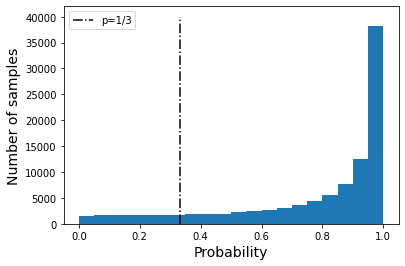

In [ ]:
_p_corrects = []
for i in range(K_CLAS):
  _p_corrects+=list(np.array(p_true[y_true[:,0]==i,i]))
_p_corrects = np.array(_p_corrects)
plt.hist(_p_corrects,bins=20)
plt.plot([1/3, 1/3],[0,40000],'k-.',label='p=1/3')
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of samples',fontsize=14)
#plt.title('Histogram of all the p(y=k|x)',fontsize=14)
plt.legend()

# Learn from Gaussian Dataset

Here we train a simple 2-layer MLP with ReLU activation. The hidden size is 128. During training, we will track these metrics:

- **loss**: the training loss of each update

(all of the following metrics are measured at the end of each epoch)

- **tacc**: accuracy on test set
- **vacc**: accuracy on validation set
- **tdistp**: L2-distance between the network's output $\mathbf{q}$ and ground truth distribution $\mathbf{p}^*$ on all training set, i.e., $\|\mathbf{q}(X_{train})-\mathbf{p}^*(X_{train})\|_2$
- **vdistp**: similar to tdistp, but on validation set
- **tdisttgt**: L2-distance between network's output and the supervision it trained on, i.e., $\|\mathbf{q}(X_{train})-\mathbf{p}_{tgt}^*(X_{train})\|_2$
- **vdisttgt**: similar to tdisttgt, but on validation set
- **tECE**: the expected calibration error of network's output on test set, refer to the appendix of the paper for more details
- **vECE**: ECE on validation set
- **L2_p_np**: the L2-distance between the ground truth distribution and its noisy version (later we will let the network directly learn under the supervision of a noisy-p)
- **IDX_MAX**: the number of the best epoch based on validation accuracy

Finally, we also report the **acc, tdistp, ECE** on test set for each model.

In [ ]:
def cal_ECE(pb_table, tf_table):
  '''
    pb_table is the probability provided by network
    tf_table is the acc results of the prodiction
  '''
  BM_acc = np.zeros((K_CLAS,))
  BM_conf = np.zeros((K_CLAS,))
  BM_cnt = np.zeros((K_CLAS,))
  Index_table = (pb_table.T*K_CLAS-1e-6).int().squeeze()

  for i in range(pb_table.shape[0]):
    idx = Index_table[i]
    BM_cnt[idx] += 1
    BM_conf[idx] += pb_table[i]
    if tf_table[i]:
      BM_acc[idx] += 1
  ECE = 0
  for j in range(K_CLAS):
    if BM_cnt[j] != 0:
      ECE += BM_cnt[j]*np.abs(BM_acc[j]/BM_cnt[j]-BM_conf[j]/BM_cnt[j])
  return ECE/BM_cnt.sum()

def L2_distance_logits_p(logits, p):
  q = F.softmax(logits,1)
  return L2_distance_q_p(q,p)
  
def L2_distance_q_p(q, p):
  return  torch.dist(q.reshape(-1,1),p.reshape(-1,1),p=2)#(nn.MSELoss(reduction='mean')(q.reshape(-1,1),p.reshape(-1,1)))**2

def cal_entropy(logits, p):
  # logits is the output of the network
  # p is the true probability (e.g. true probability)
  return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(logits,1), p)

def _y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def _y_to_smoothed(y):
  y_oht = _y_to_oht(y)
  return y_oht*LS_EPS + torch.ones_like(y_oht)*(1-LS_EPS)/K_CLAS

class MLP(nn.Module):
  def __init__(self, in_dim, hid_size=128):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size    
    self.fc1 = nn.Linear(self.in_dim, self.hid_size)
    self.fc2 = nn.Linear(self.hid_size, self.hid_size)
    self.fc3 = nn.Linear(self.hid_size, K_CLAS)
    self.act = nn.ReLU(True)

  def forward(self, x):
    h1 = self.act(self.fc1(x))
    h2 = self.act(self.fc2(h1))
    out = self.fc3(h2)
    return out

In [ ]:
def eval_model_on_test(model):
  model.eval()
  for x,y,p in test_loader:
    x,y,p = x.float().cuda(), y.long(), p.float()
    break
  hid = model(x)
  hid = hid.cpu().detach()
  pred = hid.data.max(1, keepdim=True)[1]
  prob_table = torch.gather(nn.Softmax(1)(hid),dim=1,index=pred)
  tf_table = pred.eq(y.data.view_as(pred))
  acc = tf_table.sum()/N_Test
  dist = L2_distance_logits_p(hid, p)
  ECE = cal_ECE(prob_table,tf_table)
  model.train()
  return acc, dist, ECE

def get_validation(model, data_loader, loss_type='from_oht', teacher=None):
  batch_size = data_loader.batch_size
  model.eval()
  correct = 0
  dist_p,dist_tgt = 0, 0
  pb_table, tf_table = [], []
  hid_all, p_all, p_tgt_all = [], [], []
  b_cnt = 0
  for x, y, p in data_loader:
    b_cnt += 1
    x,y,p = x.float().cuda(), y.long(), p.float()
    with torch.no_grad():
      hid = model(x)
      hid = hid.cpu().detach()
      pred = hid.data.max(1, keepdim=True)[1] # get the index of the max log-probability
      prob = torch.gather(nn.Softmax(1)(hid),dim=1,index=pred)
      y_oht=y_to_oht(y.long())
      pb_table.append(prob)
      tf_table.append(pred.eq(y.data.view_as(pred)))     

      if loss_type == 'from_oht':
        p_tgt = _y_to_oht(y)
      elif loss_type == 'from_ls':
        p_tgt = _y_to_smoothed(y)
      elif loss_type == 'from_gt' or loss_type == 'noise_prob':
        p_tgt = p
      elif loss_type == 'from_teacher':              
        teacher.eval()
        hid_teach = teacher(x)
        hid_teach = hid_teach.cpu().detach()
        p_tgt = F.softmax(hid_teach,1)
      p_all.append(p)
      hid_all.append(hid)
      p_tgt_all.append(p_tgt)
  model.train()
  pb_table = torch.stack(pb_table).reshape(-1,1)
  tf_table = torch.stack(tf_table).reshape(-1,1)
  ECE = cal_ECE(pb_table, tf_table)
  B_NUM = batch_size*b_cnt
  correct = tf_table.sum()

  hid_all = torch.stack(hid_all).reshape(-1,K_CLAS)
  p_all = torch.stack(p_all).reshape(-1,K_CLAS)
  p_tgt_all = torch.stack(p_tgt_all).reshape(-1,K_CLAS)
  dist_p = L2_distance_logits_p(hid_all, p_all)
  dist_tgt = L2_distance_logits_p(hid_all, p_tgt_all)
  return correct/B_NUM, dist_p, dist_tgt, ECE

def train(model, optimizer, scheduler, loss_type='from_oht', teacher=None, prt_flag=False, p_noise=0, noisy_type='combine',temp=1):
  results = {'loss':[], 'tacc':[], 'vacc':[], 'tdistp':[],'vdistp':[],'tdisttgt':[],'vdisttgt':[],'tECE':[],'vECE':[],'L2_ptgt_pgt':[],'IDX_MAX':[]}
  vacc_max = 0
  model.train()
  p_list, p_tgt_list = [], []
  for g in range(EPOCHS):
    for x,y,p in train_loader:
      x,y,p = x.float().cuda(), y.long().cuda(), p.float().cuda()
      optimizer.zero_grad()
      hid = model(x)

      if loss_type == 'from_oht':
        p_tgt = _y_to_oht(y)
      elif loss_type == 'from_ls':
        p_tgt = _y_to_smoothed(y)
      elif loss_type == 'from_gt':
        p_tgt = p
      elif loss_type == 'from_teacher':
        teacher.eval()
        hid_teach = teacher(x)
        hid_teach = hid_teach.detach()
        p_tgt = F.softmax(hid_teach/temp,1)
      elif loss_type == 'noise_prob':
        if noisy_type=='combine':
          p_tgt = _y_to_oht(y)*p_noise[0] + p*(1-p_noise[0])
        elif noisy_type=='plus':
          noisy_p = p + torch.from_numpy(np.random.randn(p.shape[0],p.shape[1])*np.sqrt(p_noise)).cuda()
          noisy_p = torch.clamp(noisy_p,min=1e-6,max=2)
          noisy_p = noisy_p/noisy_p.sum(1).expand([K_CLAS,-1]).transpose(0,1)
          p_tgt = noisy_p.float()          
      if g==0:          # Only calculate L2_ptgt_pgt once
        p_list.append(p)
        p_tgt_list.append(p_tgt)
      loss = cal_entropy(hid/temp, p_tgt)/(temp**2)
      loss.backward()
      optimizer.step()
      results['loss'].append(loss.item())
    # ---------- At the end of each epoch ----------
    tacc, tdistp, tdisttgt, tECE = get_validation(model, data_loader=train_loader, loss_type=loss_type, teacher=teacher)
    vacc, vdistp, vdisttgt, vECE = get_validation(model, data_loader=valid_loader, loss_type=loss_type, teacher=teacher)
    results['tacc'].append(tacc)
    results['vacc'].append(vacc)
    results['tdistp'].append(tdistp)
    results['vdistp'].append(vdistp)
    results['tdisttgt'].append(tdisttgt)
    results['vdisttgt'].append(vdisttgt)
    results['tECE'].append(tECE)
    results['vECE'].append(vECE)
    if vacc>vacc_max:
      vacc_max = vacc
      ES_model = copy.deepcopy(model)
      results['IDX_MAX']=g
    if prt_flag and g%10==0:
      print('\t==Training , Epoch: {:3d}/{:3d}\tLoss: {:.6f}\tTACC: {:.6f},\tVACC:{:.6f}'.format(g,EPOCHS, results['loss'][-1], tacc, vacc))
    scheduler.step()
  results['L2_ptgt_pgt'] = L2_distance_q_p(torch.stack(p_list).reshape(-1,K_CLAS), torch.stack(p_tgt_list).reshape(-1,K_CLAS)).cpu()
  return ES_model, results

## Experiment 1: verification of Hypothesis 1 (section 2.3 in paper)

Recall hypothesis 1: Suppose we train a model under the supervision of ${p}_\text{tar}$, i.e., minimize $R_\text{tar}(f,\mathcal{D}')$, suppose we have enough training samples, the average L2-distance between ${p}_\text{tar}$ and the ground truth ${p}^*$ on these samples, i.e., $\mathbb{E}_{{x}\sim\mathcal{D}'}\left[\|{p}_\text{tar}({x})-{p}^*({x})\|_2\right]$ is positively correlated with the model's generalization performance.

From hypothesis 1, we might expect the following 2 things happen:

- A neural network trained using better ${p}_\text{tar}$ can have lower accuracy (ACC) and lower expected calibration error (ECE) on test set. 
- If the NN is directly trained using ${p}^*$, the performance should be close to a theoretical bound obtained by the optimal Bayesian classifier. (Refer to the appendix A in the paper to find how this bound is calculated.)

In this experiment, we also provide three baselines for comparison:

- **OHT**: learning from one-hot label
- **LS**: learning using label smoothing
- **GT**: learning from ground truth probability
- **KD**: learning from the converged OHT label
- **ESKD**: learning from early-stopped model during the training of OHT model

### Four baselines

In [ ]:
OHT_model = MLP(in_dim=X_DIM).cuda()
OHT_optimizer = optim.SGD(OHT_model.parameters(), lr=LR, momentum=0.9)
OHT_scheduler = optim.lr_scheduler.CosineAnnealingLR(OHT_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_OHT_model, OHT_results = train(OHT_model, OHT_optimizer, OHT_scheduler, 'from_oht',prt_flag=True)

	==Training , Epoch:   0/100	Loss: 0.783755	TACC: 0.780649,	VACC:0.768800
	==Training , Epoch:  10/100	Loss: 0.459686	TACC: 0.850962,	VACC:0.840200
	==Training , Epoch:  20/100	Loss: 0.173808	TACC: 0.859976,	VACC:0.839600
	==Training , Epoch:  30/100	Loss: 0.438397	TACC: 0.869191,	VACC:0.840200
	==Training , Epoch:  40/100	Loss: 0.291491	TACC: 0.877604,	VACC:0.838200
	==Training , Epoch:  50/100	Loss: 0.345821	TACC: 0.884615,	VACC:0.836200
	==Training , Epoch:  60/100	Loss: 0.171114	TACC: 0.894631,	VACC:0.833200
	==Training , Epoch:  70/100	Loss: 0.333472	TACC: 0.903646,	VACC:0.832000
	==Training , Epoch:  80/100	Loss: 0.240411	TACC: 0.911258,	VACC:0.830200
	==Training , Epoch:  90/100	Loss: 0.429090	TACC: 0.917268,	VACC:0.826000


In [ ]:
LS_EPS = (1-0.03)   
LS_model = MLP(in_dim=X_DIM).cuda()
LS_optimizer = optim.SGD(LS_model.parameters(), lr=LR, momentum=0.9)
LS_scheduler = optim.lr_scheduler.CosineAnnealingLR(LS_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_LS_model, LS_results = train(LS_model, LS_optimizer, LS_scheduler, 'from_ls',prt_flag=True)

	==Training , Epoch:   0/100	Loss: 0.805147	TACC: 0.735577,	VACC:0.720800
	==Training , Epoch:  10/100	Loss: 0.285832	TACC: 0.847155,	VACC:0.835800
	==Training , Epoch:  20/100	Loss: 0.361682	TACC: 0.855369,	VACC:0.837400
	==Training , Epoch:  30/100	Loss: 0.323992	TACC: 0.865385,	VACC:0.837000
	==Training , Epoch:  40/100	Loss: 0.236004	TACC: 0.874599,	VACC:0.835600
	==Training , Epoch:  50/100	Loss: 0.242457	TACC: 0.883413,	VACC:0.832600
	==Training , Epoch:  60/100	Loss: 0.175674	TACC: 0.892829,	VACC:0.833400
	==Training , Epoch:  70/100	Loss: 0.163700	TACC: 0.901442,	VACC:0.833200
	==Training , Epoch:  80/100	Loss: 0.199810	TACC: 0.908053,	VACC:0.832200
	==Training , Epoch:  90/100	Loss: 0.330957	TACC: 0.915465,	VACC:0.828200


In [ ]:
GT_model = MLP(in_dim=X_DIM).cuda()
GT_optimizer = optim.SGD(GT_model.parameters(), lr=LR, momentum=0.9)
GT_scheduler = optim.lr_scheduler.CosineAnnealingLR(GT_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_GT_model, GT_results = train(GT_model, GT_optimizer, GT_scheduler, 'from_gt',prt_flag=True)

	==Training , Epoch:   0/100	Loss: 0.404297	TACC: 0.741787,	VACC:0.745600
	==Training , Epoch:  10/100	Loss: 0.017078	TACC: 0.834535,	VACC:0.836000
	==Training , Epoch:  20/100	Loss: 0.009469	TACC: 0.837740,	VACC:0.838800
	==Training , Epoch:  30/100	Loss: 0.005915	TACC: 0.838742,	VACC:0.840200
	==Training , Epoch:  40/100	Loss: 0.013571	TACC: 0.841146,	VACC:0.841800
	==Training , Epoch:  50/100	Loss: 0.006275	TACC: 0.841546,	VACC:0.842800
	==Training , Epoch:  60/100	Loss: 0.007221	TACC: 0.842949,	VACC:0.844600
	==Training , Epoch:  70/100	Loss: 0.007056	TACC: 0.842748,	VACC:0.844600
	==Training , Epoch:  80/100	Loss: 0.003989	TACC: 0.843750,	VACC:0.844600
	==Training , Epoch:  90/100	Loss: 0.004542	TACC: 0.842748,	VACC:0.846000


In [ ]:
KD_model = MLP(in_dim=X_DIM).cuda()
KD_optimizer = optim.SGD(KD_model.parameters(), lr=LR, momentum=0.9)
KD_scheduler = optim.lr_scheduler.CosineAnnealingLR(KD_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_KD_model, KD_results = train(KD_model, KD_optimizer, KD_scheduler, 'from_teacher',teacher=OHT_model,prt_flag=True)

	==Training , Epoch:   0/100	Loss: 0.593286	TACC: 0.731971,	VACC:0.731600
	==Training , Epoch:  10/100	Loss: 0.164156	TACC: 0.846955,	VACC:0.837800
	==Training , Epoch:  20/100	Loss: 0.086188	TACC: 0.853165,	VACC:0.839400
	==Training , Epoch:  30/100	Loss: 0.044294	TACC: 0.858974,	VACC:0.840400
	==Training , Epoch:  40/100	Loss: 0.062334	TACC: 0.864183,	VACC:0.840200
	==Training , Epoch:  50/100	Loss: 0.061350	TACC: 0.868590,	VACC:0.838600
	==Training , Epoch:  60/100	Loss: 0.035931	TACC: 0.871995,	VACC:0.837800
	==Training , Epoch:  70/100	Loss: 0.049828	TACC: 0.874599,	VACC:0.837600
	==Training , Epoch:  80/100	Loss: 0.029782	TACC: 0.879006,	VACC:0.836400
	==Training , Epoch:  90/100	Loss: 0.016668	TACC: 0.882412,	VACC:0.837400


In [ ]:
ESKD_model = MLP(in_dim=X_DIM).cuda()
ESKD_optimizer = optim.SGD(ESKD_model.parameters(), lr=LR, momentum=0.9)
ESKD_scheduler = optim.lr_scheduler.CosineAnnealingLR(ESKD_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_ESKD_model, ESKD_results = train(ESKD_model, ESKD_optimizer, ESKD_scheduler, 'from_teacher',teacher=best_OHT_model,prt_flag=True)

	==Training , Epoch:   0/100	Loss: 0.432311	TACC: 0.741186,	VACC:0.732800
	==Training , Epoch:  10/100	Loss: 0.038155	TACC: 0.845753,	VACC:0.840800
	==Training , Epoch:  20/100	Loss: 0.012359	TACC: 0.845954,	VACC:0.841200
	==Training , Epoch:  30/100	Loss: 0.037602	TACC: 0.845954,	VACC:0.843200
	==Training , Epoch:  40/100	Loss: 0.020424	TACC: 0.848157,	VACC:0.843600
	==Training , Epoch:  50/100	Loss: 0.013502	TACC: 0.847556,	VACC:0.844000
	==Training , Epoch:  60/100	Loss: 0.015018	TACC: 0.848558,	VACC:0.844400
	==Training , Epoch:  70/100	Loss: 0.019693	TACC: 0.847957,	VACC:0.845000
	==Training , Epoch:  80/100	Loss: 0.013214	TACC: 0.847957,	VACC:0.845000
	==Training , Epoch:  90/100	Loss: 0.011514	TACC: 0.848958,	VACC:0.845400


In [ ]:
tmp_oht_q, tmp_ls_q, tmp_kd_q, tmp_eskd_q, tmp_all_p = [], [], [], [], []
for tx,ty,tp in train_loader:
  tx,ty = tx.float().cuda(),ty.long()
  kd_hid = OHT_model(tx).cpu()
  kd_pred = nn.Softmax(1)(kd_hid)
  eskd_hid = best_OHT_model(tx).cpu()
  eskd_pred = nn.Softmax(1)(eskd_hid)
  ls = (_y_to_oht(ty)*LS_EPS+(1-LS_EPS)/(K_CLAS-1)*torch.ones(BATCH_SIZE,K_CLAS))

  tmp_oht_q.append(_y_to_oht(ty))
  tmp_ls_q.append(ls)
  tmp_kd_q.append(kd_pred)
  tmp_eskd_q.append(eskd_pred)
  tmp_all_p.append(tp)
tmp_oht_q = torch.stack(tmp_oht_q).reshape(-1,K_CLAS)
tmp_ls_q = torch.stack(tmp_ls_q).reshape(-1,K_CLAS)
tmp_kd_q = torch.stack(tmp_kd_q).reshape(-1,K_CLAS)
tmp_eskd_q = torch.stack(tmp_eskd_q).reshape(-1,K_CLAS)
tmp_all_p = torch.stack(tmp_all_p).reshape(-1,K_CLAS)

dist_oht_to_p = L2_distance_q_p(tmp_oht_q, tmp_all_p).item()
dist_ls_to_p = L2_distance_q_p(tmp_ls_q, tmp_all_p).item()
dist_kd_to_p = L2_distance_q_p(tmp_kd_q, tmp_all_p).item()
dist_eskd_to_p = L2_distance_q_p(tmp_eskd_q, tmp_all_p).item()
print('OHT\t'+str(dist_oht_to_p))
print('LS\t'+str(dist_ls_to_p))
print('KD\t'+str(dist_kd_to_p))
print('ESKD\t'+str(dist_eskd_to_p))

OHT	33.25286048769626
LS	32.2937461393822
KD	16.461855929117295
ESKD	7.61864426066026


In [ ]:
"""
ls_distp, kd_distp, eskd_distp = [],[],[]

TMP_TABLE = [0.5, 1.5, 2, 3, 4]
LS_TABLE = [0.9, 0.85, 0.8, 0.75, 0.7]

def get_ls_dist_q(ls_ratio):
  tmp_ls_q,tmp_all_p=[],[]
  for tx,ty,tp in train_loader:
    ty = ty.long()
    ls = (_y_to_oht(ty)*ls_ratio+(1-ls_ratio)/(K_CLAS-1)*torch.ones(BATCH_SIZE,K_CLAS))
    tmp_ls_q.append(ls)
    tmp_all_p.append(tp)
  tmp_ls_q = torch.stack(tmp_ls_q).reshape(-1,K_CLAS)
  tmp_all_p = torch.stack(tmp_all_p).reshape(-1,K_CLAS)
  return L2_distance_q_p(tmp_ls_q, tmp_all_p).item()

def get_ls_dist_kd(temp):
  tmp_kd_q,tmp_eskd_q,tmp_all_p=[],[],[]
  for tx,ty,tp in train_loader:
    tx,ty = tx.float().cuda(),ty.long()
    kd_hid = OHT_model(tx).cpu()
    kd_pred = nn.Softmax(1)(kd_hid/temp)
    eskd_hid = best_OHT_model(tx).cpu()
    eskd_pred = nn.Softmax(1)(eskd_hid/temp)
    tmp_kd_q.append(kd_pred)
    tmp_eskd_q.append(eskd_pred)
    tmp_all_p.append(tp)
  tmp_kd_q = torch.stack(tmp_kd_q).reshape(-1,K_CLAS)
  tmp_eskd_q = torch.stack(tmp_eskd_q).reshape(-1,K_CLAS)
  tmp_all_p = torch.stack(tmp_all_p).reshape(-1,K_CLAS)
  return L2_distance_q_p(tmp_kd_q, tmp_all_p).item(), L2_distance_q_p(tmp_eskd_q, tmp_all_p).item()

for ls in LS_TABLE:
  ls_distp.append(get_ls_dist_q(ls))

for temp in TMP_TABLE:
  tmp_kd, tmp_eskd = get_ls_dist_kd(temp)
  kd_distp.append(tmp_kd)
  eskd_distp.append(tmp_eskd)
"""

In [ ]:
def show_test_results(model, type_='OHT'):
  acc, distp, ECE = eval_model_on_test(model)
  print(type_+': \t Test acc is %.5f; tdistp is %.5f; ECE is %.5f'%(acc.item(), distp.item(), ECE.item()))
  return acc, distp, ECE

In [ ]:
OHT_test_acc, OHT_test_distp, OHT_test_ECE = show_test_results(best_OHT_model, 'OHT ')
LS_test_acc, LS_test_distp, LS_test_ECE = show_test_results(best_LS_model, ' LS ')
GT_test_acc, GT_test_distp, GT_test_ECE = show_test_results(best_GT_model, ' GT ')
KD_test_acc, KD_test_distp, KD_test_ECE = show_test_results(best_KD_model,' KD ')
ESKD_test_acc, ESKD_test_distp, ESKD_test_ECE = show_test_results(best_ESKD_model,'ESKD')

OHT : 	 Test acc is 0.83391; tdistp is 34.04276; ECE is 0.01444
 LS : 	 Test acc is 0.83221; tdistp is 36.87823; ECE is 0.00537
 GT : 	 Test acc is 0.84024; tdistp is 17.24724; ECE is 0.00346
 KD : 	 Test acc is 0.83273; tdistp is 37.12327; ECE is 0.02456
ESKD: 	 Test acc is 0.83647; tdistp is 27.87039; ECE is 0.00604


## Learn from LS/KD/ESKD with different temp.

In [ ]:
"""
ls_acc, ls_ECE = [],[]
for i in range(5):
  print(i,end='-')
  LS_EPS = LS_TABLE[i]#(1-0.001*(i+1))   
  tmp_model = MLP(in_dim=X_DIM).cuda()
  tmp_optimizer = optim.SGD(tmp_model.parameters(), lr=LR, momentum=0.9)
  tmp_scheduler = optim.lr_scheduler.CosineAnnealingLR(tmp_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
  tmp_best_model, _ = train(tmp_model, tmp_optimizer, tmp_scheduler, 'from_ls',prt_flag=False)
  acc, _, ECE = eval_model_on_test(tmp_best_model)
  ls_acc.append(acc)
  ls_ECE.append(ECE)
  """

0-1-2-3-4-

In [ ]:
"""
kd_acc, kd_ECE = [],[]

for i in range(5):
  print(i,end='-')
  temp = TMP_TABLE[i]
  tmp_model = MLP(in_dim=X_DIM).cuda()
  tmp_optimizer = optim.SGD(tmp_model.parameters(), lr=LR, momentum=0.9)
  tmp_scheduler = optim.lr_scheduler.CosineAnnealingLR(tmp_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
  tmp_best_model, _ = train(tmp_model, tmp_optimizer, tmp_scheduler, 'from_teacher',teacher=OHT_model,prt_flag=False,temp=temp)
  acc, _, ECE = eval_model_on_test(tmp_best_model)
  kd_acc.append(acc)
  kd_ECE.append(ECE)
  """

0-

In [ ]:
"""
eskd_acc, eskd_ECE = [],[]
for i in range(5):
  print(i,end='-')
  temp = TMP_TABLE[i]
  tmp_model = MLP(in_dim=X_DIM).cuda()
  tmp_optimizer = optim.SGD(tmp_model.parameters(), lr=LR, momentum=0.9)
  tmp_scheduler = optim.lr_scheduler.CosineAnnealingLR(tmp_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
  tmp_best_model, _ = train(tmp_model, tmp_optimizer, tmp_scheduler, 'from_teacher',teacher=best_OHT_model,prt_flag=False,temp=temp)
  acc, _, ECE = eval_model_on_test(tmp_best_model)
  eskd_acc.append(acc)
  eskd_ECE.append(ECE)
  """

0-1-2-3-4-

### Learn from $\mathbf{p}_{tgt}$ with different noise

Type-I noise: combine noise, i.e., $\mathbf{p}_{tgt}=\eta\mathbf{p}^*+(1-\eta)\mathbf{e}_y$ (We use this one in the paper).

Type-II noise: plus noise, i.e., $\mathbf{p}_{tgt}=\text{Norm}[\mathbf{p}^*+\epsilon], \epsilon\sim\mathcal{N}(0,\sigma_p^2)$ as the target probability. $\text{Norm}[x]$ will force $x$ to be a valid categorical distribution. (Older version has result in this one, but we guess the result is hard to explain so we delete it in the camera-ready version.)

In [ ]:
test_acc_list_combine = []
test_distp_list_combine = []
test_ECE_list_combine = []
L2_ptgt_pgt_list_combine = []
for i in range(100):
  print(i,end='-')
  noise_level = np.random.uniform(0,1,1)
  S4_model = MLP(in_dim=X_DIM).cuda()
  S4_optimizer = optim.SGD(S4_model.parameters(), lr=LR, momentum=0.9)
  S4_scheduler = optim.lr_scheduler.CosineAnnealingLR(S4_optimizer, T_max=EPOCHS, eta_min=LR_MIN) 
  best_S4_model, S4_results = train(S4_model, S4_optimizer, S4_scheduler, 'noise_prob', p_noise=noise_level,noisy_type='combine')
  acc, distp, ECE = eval_model_on_test(best_S4_model)
  test_acc_list_combine.append(acc)
  test_distp_list_combine.append(distp)
  test_ECE_list_combine.append(ECE)
  L2_ptgt_pgt_list_combine.append(S4_results['L2_ptgt_pgt'])

for i in range(20):
  print(i,end='-')
  noise_level = np.random.uniform(0,0.5,1)
  S4_model = MLP(in_dim=X_DIM).cuda()
  S4_optimizer = optim.SGD(S4_model.parameters(), lr=LR, momentum=0.9)
  S4_scheduler = optim.lr_scheduler.CosineAnnealingLR(S4_optimizer, T_max=EPOCHS, eta_min=LR_MIN) 
  best_S4_model, S4_results = train(S4_model, S4_optimizer, S4_scheduler, 'noise_prob', p_noise=noise_level,noisy_type='combine')
  acc, distp, ECE = eval_model_on_test(best_S4_model)
  test_acc_list_combine.append(acc)
  test_distp_list_combine.append(distp)
  test_ECE_list_combine.append(ECE)
  L2_ptgt_pgt_list_combine.append(S4_results['L2_ptgt_pgt'])


0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-

In [ ]:
np.save('Project1/results/L2_ptgt_pgt_list_combine_N'+str(NOISE)+'.npy',np.array(L2_ptgt_pgt_list_combine))
np.save('Project1/results/test_acc_list_combine_N'+str(NOISE)+'.npy',np.array(test_acc_list_combine))
scipy.stats.spearmanr(L2_ptgt_pgt_list_combine, test_acc_list_combine)

SpearmanrResult(correlation=-0.9309152786843132, pvalue=1.9018749279756831e-53)

In [ ]:
#L2_ptgt_pgt_list_combine = np.load('Project1/results/L2_ptgt_pgt_list_combine_N'+str(NOISE)+'.npy')
#test_acc_list_combine = np.load('Project1/results/test_acc_list_combine_N'+str(NOISE)+'.npy')
#test_ECE_list_combine = np.load('Project1/results/test_ECE_list_combine_N'+str(NOISE)+'.npy')

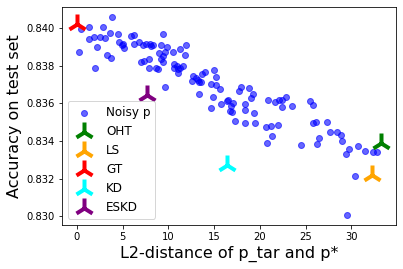

In [ ]:
plt.scatter(L2_ptgt_pgt_list_combine, test_acc_list_combine, color='blue',alpha=0.6,label='Noisy p')
plt.scatter(dist_oht_to_p,OHT_test_acc,color='green',label='OHT',marker='2',s=400,linewidth=4)
plt.scatter(dist_ls_to_p,LS_test_acc,color='orange',label='LS',marker='2',s=400,linewidth=4)
plt.scatter(0,GT_test_acc,color='red',label='GT',marker='2',s=400,linewidth=4)
plt.scatter(dist_kd_to_p,KD_test_acc,color='cyan',label='KD',marker='2',s=400,linewidth=4)
plt.scatter(dist_eskd_to_p,ESKD_test_acc,color='purple',label='ESKD',marker='2',s=400,linewidth=4)

#plt.scatter(kd_distp,kd_acc,color='cyan',marker='2',s=400,linewidth=4)
#plt.scatter(ls_distp,ls_acc,color='orange',alpha=0.7,marker='2',s=400,linewidth=4)
#plt.scatter(eskd_distp,eskd_acc,color='purple',marker='2',s=400,linewidth=4)

plt.legend(fontsize=12)
plt.ylabel('Accuracy on test set', fontsize=16)
plt.xlabel('L2-distance of p_tar and p*',fontsize=16)
plt.savefig('Project1/Figures/rbt_toy_acc_L2_N'+str(NOISE)+'.pdf')

In [ ]:
np.save('Project1/results/L2_ptgt_pgt_list_combine_N'+str(NOISE)+'.npy',np.array(L2_ptgt_pgt_list_combine))
np.save('Project1/results/test_ECE_list_combine_N'+str(NOISE)+'.npy',np.array(test_ECE_list_combine))
scipy.stats.spearmanr(L2_ptgt_pgt_list_combine, test_ECE_list_combine)

SpearmanrResult(correlation=0.8954719077713729, pvalue=2.705262593852301e-43)

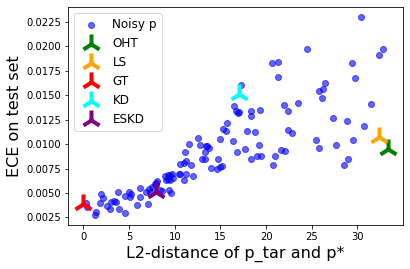

In [ ]:
plt.scatter(L2_ptgt_pgt_list_combine,test_ECE_list_combine, color='blue',alpha=0.6,label='Noisy p')
plt.scatter(OHT_results['L2_ptgt_pgt'],OHT_results['vECE'][OHT_results['IDX_MAX']],color='green',label='OHT',marker='2',s=400,linewidth=4)
plt.scatter(LS_results['L2_ptgt_pgt'],LS_results['vECE'][LS_results['IDX_MAX']], color='orange',label='LS',marker='2',s=400,linewidth=4)
plt.scatter(GT_results['L2_ptgt_pgt'],GT_results['vECE'][GT_results['IDX_MAX']], color='red',label='GT',marker='2',s=400,linewidth=4)
plt.scatter(KD_results['L2_ptgt_pgt'],KD_results['vECE'][KD_results['IDX_MAX']], color='cyan',label='KD',marker='2',s=400,linewidth=4)
plt.scatter(ESKD_results['L2_ptgt_pgt'],ESKD_results['vECE'][ESKD_results['IDX_MAX']], color='purple',label='ESKD',marker='2',s=400,linewidth=4)

#plt.scatter(kd_distp,kd_ECE,color='cyan',marker='2',s=400,linewidth=4)
#plt.scatter(ls_distp,ls_ECE,color='orange',alpha=0.7,marker='2',s=400,linewidth=4)
#plt.scatter(eskd_distp,eskd_ECE,color='purple',marker='2',s=400,linewidth=4)
plt.legend(fontsize=12)
#plt.xlim(-0.02,0.3)
#plt.ylim(-0.02,0.21)

plt.ylabel('ECE on test set', fontsize=16)
plt.xlabel('L2-distance of p_tar and p*',fontsize=16)
plt.savefig('Project1/Figures/rbt_toy_ECE_L2_N'+str(NOISE)+'.pdf')